# Introduction

This notebook was used to optimize the prediction model. We ran grid searches with a GTX 1060 GPU in order to find the best hyperparameters, that is to say the parameters which achieved a good RMSE score on the test dataset while keeping a certain amount of error on the train dataset in order to `prevent overfitting`.

In [2]:
%matplotlib inline
import os
import time
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import problem

import xgboost as xgb
from catboost import CatBoostRegressor

from joblib import dump, load
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV




pd.set_option('display.max_columns', None)



# Model 1 : XGBoost

After trying lasso and ridge regressions, we decided to move on to random forests in order to benefit from their predictive power. We finally settled on boosted trees, which learn from previous trees compared to the random forest model. The RMSE gain was immediatly significant, with a train RMSE score going from 0.4 to 0.3 without any hyperparameters tuning.

The following steps show how we used Grid Searches in order to tune those parameters.

In [20]:
merging_keys = ['DateOfDeparture', 'Departure', 'Arrival'] # keys to merge external_data.csv and the main data

def _merge_external_data(X):
    filepath = os.path.join(
        'submissions', 'cat', 'external_data.csv'
    )

    filepath = 'external_data.csv'

    X = X.copy()
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    
    # Parse date to also be of dtype datetime
    data_w = pd.read_csv(filepath)
    data_w.loc[:, "DateOfDeparture"] = pd.to_datetime(data_w['DateOfDeparture'])

    X_merged = X.merge(data_w, how='left', on=['DateOfDeparture', 'Departure', 'Arrival'])

    return X_merged

def get_estimator():

    data_merger = FunctionTransformer(_merge_external_data)
    

    date_cols = ["DateOfDeparture"]

    categorical_encoder = make_pipeline(
        SimpleImputer(strategy='constant', fill_value="missing"),
        OrdinalEncoder()
    )
    

    categorical_cols = ['Arrival', 'Departure']

    preprocessor = make_column_transformer(
        (categorical_encoder, categorical_cols),
        remainder='passthrough',  # passthrough numerical columns as they are
    )


    regressor = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective ='reg:squarederror', 
    eval_metric='rmse', colsample_bytree = 0.5, learning_rate = 0.05, 
    max_depth = 8, alpha = 2, n_estimators = 2500, max_leaves=10)


    return make_pipeline(data_merger, preprocessor, regressor)

In [8]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()
pipeline = get_estimator()

## Parameters Grid Search

In [9]:
param_grid = {

    'xgbregressor__max_depth': [5, 8, 10],
    'xgbregressor__n_estimators': [2000, 5000],
     'xgbregressor__colsample_bylevel' : [0.3, 0.5, 0.8],
     'xgbregressor__colsample_bynode' : [0.3, 0.5, 0.8],
     'xgbregressor__max_leaves' : [3, 5, 10, 15]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=2)


In [10]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   53.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 18.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 22.0min
[Parall

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _merge_external_data at 0x000001B3FE502EE0>)),
                                       ('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function _encode_dates at 0x000001B3FE502820>),
                                                                         ['DateOfDeparture']),
                                                                        ('pipeline',
                                                                         Pi...
                                                     subsample=None,
                                                     tree_method='gpu_hist',
    

In [16]:
df_res = pd.DataFrame(data = grid.cv_results_).sort_values("rank_test_score")
params = df_res.tail(1)["params"].values
print(params)
dump(grid, 'grid_search.joblib') 
df_res.to_excel("grid_search_save_results.xlsx", index=False)

[{'xgbregressor__colsample_bylevel': 0.3, 'xgbregressor__colsample_bynode': 0.3, 'xgbregressor__max_depth': 5, 'xgbregressor__max_leaves': 3, 'xgbregressor__n_estimators': 2000}]


## PCA Grid Search 

In [37]:
param_grid = {
    'pca__n_components': [4, 6, 8, 10, 12, 15, 16],
    'xgbregressor__max_depth': [5],
    # 'xgbregressor__n_estimators': [1000, 2000, 2500],
    'xgbregressor__alpha' : [2],
    'xgbregressor__learning_rate' : [0.01]
}

grid_pca = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=2)

In [25]:
## SAUVEGARDE PCA###

df_save = df_res_pca.copy()
df_save.head()

df_save.to_excel("grid_pca_save_result.xlsx", index=False)



In [38]:
%%time
grid_pca.fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   31.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:  4.7min finished
Wall time: 4min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _merge_external_data at 0x000001E085BAEDC0>)),
                                       ('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function _encode_dates at 0x000001E08658C820>),
                                                                         ['DateOfDeparture']),
                                                                        ('pipeline',
                                                                         Pi...
                                                     num_parallel_tree=1,
                                                     random_state=0,
       

In [39]:
df_res_pca = pd.DataFrame(data = grid_pca.cv_results_).sort_values("rank_test_score")
df_res_pca.head()
params = df_res_pca.head(1)["params"].values
print(params)

[{'pca__n_components': 16, 'xgbregressor__alpha': 2, 'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 5}]


# Model 2 : CatBoost

As we reached a performance plateau with the XGBoost model, we decided to try another boosted forest model, CatBoost. Its particularity lies in its ability to correctly process categorical data without any one-hot encode : this was an issue with our XGBoost model as it could not correctly process the "Departure" and "Arrival" categorical features. And a one-hot encode led to the creation of 36 distinct columns in order to correctly encode them.

CatBoost also immediately led to a performance boost, as our RMSE went from 0.3 to 0.284 without a lot of hyperparameters optimization. We then ran another GridSearch in order to optimize this model.

In [1]:
merging_keys = ['DateOfDeparture', 'Departure', 'Arrival'] # keys to merge external_data.csv and the main data


ext_data_predictors = ["Frequency", "Delta", "Price"]
int_data_predictors = ["WeeksToDeparture"]

all_predictors = merging_keys + ext_data_predictors + int_data_predictors

def get_estimator():

    data_merger = FunctionTransformer(_merge_external_data)
    regressor = CatBoostRegressor(n_estimators=2500, colsample_bylevel=0.3, learning_rate=0.1, verbose=1000, reg_lambda=1,
    cat_features=["Departure", "Arrival"])


    return make_pipeline(data_merger, regressor)

## Parameters Grid Search

In [ ]:
param_grid = {

    'catboostregressor__max_depth': [5, 8, 10],
    'catboostregressor__n_estimators': [2000, 5000],
     'catboostregressor__colsample_bylevel' : [0.3, 0.5, 0.8],
     'catboostregressor__colsample_bynode' : [0.3, 0.5, 0.8],
     'catboostregressor__max_leaves' : [3, 5, 10, 15]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=2)

In [38]:
data_train = pd.read_csv(
    os.path.join('data', 'train.csv.bz2')
)
data_test = pd.read_csv(
    os.path.join('data', 'test.csv.bz2')
) 


X_train, y_train = data_train.drop(columns=["log_PAX"]), data_train["log_PAX"]


pipeline = get_estimator()

pipeline.fit(X_train, y_train)


0:	learn: 0.9475478	total: 21.6ms	remaining: 54.1s
1000:	learn: 0.2076822	total: 24.1s	remaining: 36s
2000:	learn: 0.1458945	total: 46.3s	remaining: 11.6s
2499:	learn: 0.1263888	total: 57.4s	remaining: 0us


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001A4D948EDC0>)),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001A4D82DA400>)])

[10.26108596  1.15212354  2.14518692  4.56162437  2.41268537 20.83854417
  0.84393408  1.20907508  1.25801035  1.16768315  4.72738375  1.20705988
  1.85972962  1.60948231  4.74652286  5.35061181  4.56844509 30.08081171]
['DateOfDeparture', 'Departure', 'Arrival', 'WeeksToDeparture', 'std_wtd', 'Flight baseline frequentation', 'weekly_volume', 'density_departure', 'population_arrival', 'density_arrival', 'distance', 'domestic_dep_month_vol', 'internat_dep_month_vol', 'total_dep_month_vol', 'a_airlines', 'delta', 'booking', 'weekday']


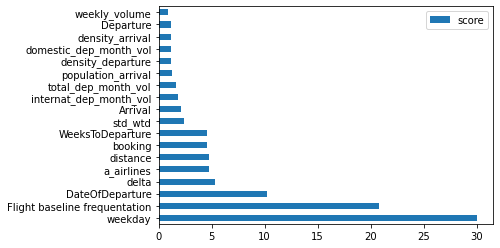

In [39]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'
print(pipeline[1].get_feature_importance())
print(pipeline[1].feature_names_)

feature_importance = pd.DataFrame(data=pipeline[1].get_feature_importance(), index = pipeline[1].feature_names_, columns=["score"])
feature_importance = feature_importance.sort_values(by = "score", ascending=False)
feature_importance.plot(kind='barh')
plt.savefig('features_importance.png', facecolor='w', bbox_inches='tight')

In [33]:
dot = pipeline[1].plot_tree(tree_idx=0)
dot.render('tree.png', view=True) 

'tree.png.pdf'